# Transfer Learning with Convolutional Neural Networks For Classification


## Import Libraries and Auxiliary Functions

In [1]:
import os
import uuid
import shutil
import json
import copy
from datetime import datetime

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 

Deep Learning Libraries, set seed for reproducibility


In [3]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

Plot train cost and validation accuracy:


In [4]:
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

Testing plot the transformed image:


In [5]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(2,2))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

To show the prediction and actual value:


In [6]:
def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

Define our device as the first visible cuda device if we have CUDA available:


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)


the device type is cpu


## Load Data

Note that here we got to standardization with:

<code>
<p>mean = [0.485, 0.456, 0.406]</p>
<p>std = [0.229, 0.224, 0.225]</p>
    </code>


the data is in the images folder


In [8]:
# some cleaning up of the images folder
import os

def remove_ds_store_files(folder):
  # Get the names of the files and subfolders in the folder
  file_names = os.listdir(folder)
  # Iterate over the files and subfolders
  for file_name in file_names:
    # Get the path to the file or subfolder
    path = os.path.join(folder, file_name)
    # Check if the file or subfolder is a `.DS_Store` file
    if file_name == '.DS_Store':
      # Delete the `.DS_Store` file
      os.remove(path)
    # Check if the file or subfolder is a directory
    elif os.path.isdir(path):
      # Recursively call the function to delete `.DS_Store` files in the subfolder (macbook)
      remove_ds_store_files(path)


def delete_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(e)

# Test the function
remove_ds_store_files('images')
remove_ds_store_files('images_folders')
delete_folder_contents('images')


We need to get our training and validation dataset. 90% of the data will be used for training.


In [9]:
from do_annotate import do_annotate

do_annotate()

In [10]:
# import the getDataset helper function for dataset class from get_dataset.py
from get_dataset import getDataset

annotations = json.load(open('images/_annotations.json'))
percentage_train=0.9
train_set=getDataset(annotations,train_test='train',percentage_train=percentage_train)
val_set=getDataset(annotations,train_test='test',percentage_train=percentage_train)

Using default bucket name: default_bucket
defult transform for pretrained model resnet18
labels_filename DNE. Creating new labels file from annotations...
this is the training set
Using default bucket name: default_bucket
defult transform for pretrained model resnet18
labels_filename DNE. Creating new labels file from annotations...
this is the test set


Plot some of our dataset:


(224, 224, 3)


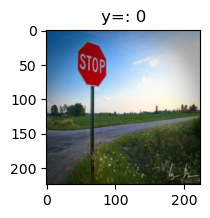

(224, 224, 3)


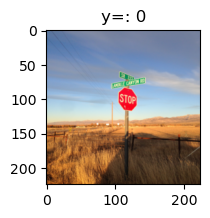

(224, 224, 3)


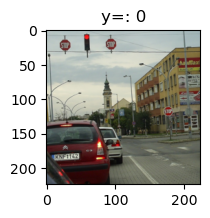

(224, 224, 3)


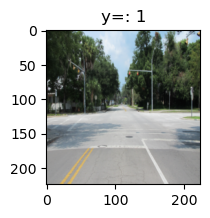

(224, 224, 3)


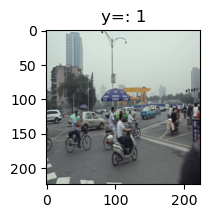

(224, 224, 3)


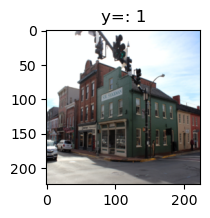

In [11]:
i=0

for x,y  in val_set:
    i+=1
    if i % 3 == 0:
        imshow_(x,"y=: {}".format(str(y.item())))
    if i == 19:
        break

Experiment with different hyperparameters:


In [12]:
n_epochs=15
batch_size=32
lr=0.000001

<b>Momentum</b> is a term used in the gradient descent algorithm to improve training results.
If you set to <code>lr_scheduler=True</code>  for every epoch use a learning rate scheduler changes the range of the learning rate from a maximum or minimum value. The learning rate usually decays over time.


In [13]:
momentum=0.9
lr_scheduler=True
base_lr=0.001
max_lr=0.01

# Load Model and Train it


In [14]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
            # Forward pass
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

Load the pre-trained model resnet18. Set the parameter pretrained to true.


In [15]:
model = models.resnet18(pretrained=True)

/Users/zzp/opt/anaconda3/envs/py39_PyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/zzp/opt/anaconda3/envs/py39_PyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We will only train the last layer of the network set the parameter <code>requires_grad</code> to <code>False</code>, the network is a fixed feature extractor.


In [16]:
for param in model.parameters():
       param.requires_grad = False
    

Number of classes


In [17]:
n_classes=train_set.n_classes
n_classes

2

Replace the output layer model.fc of the neural network with a nn.Linear object, to classify <code>n_classes</code> different classes. For the parameters in_features  remember the last hidden layer has 512 neurons.


In [18]:
model.fc = nn.Linear(512, n_classes)

Set device type


In [19]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Cross-entropy loss, or log loss, measures the performance of a classification model combines LogSoftmax in one object class. It is useful when training a classification problem with C classes.


In [20]:
criterion = nn.CrossEntropyLoss()

Create a training loader and validation loader object.


In [21]:

train_loader = torch.utils.data.DataLoader(dataset=train_set , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)

Use the optim package to define an Optimizer that will update the weights of the model for us.


In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


We use <a href='https://arxiv.org/pdf/1506.01186.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01'>Cyclical Learning Rates</a>


In [23]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

Now we are going to train model,for 500 images this take 25 minutes, depending on your dataset


In [24]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

  0%|          | 0/15 [00:00<?, ?it/s]

epoch 0 done


  7%|▋         | 1/15 [00:09<02:13,  9.52s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 0.7570649683475494
The validation accuracy for epoch 1: 0.55
epoch 1 done


 13%|█▎        | 2/15 [00:18<02:03,  9.48s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.6165517469247183
The validation accuracy for epoch 2: 0.65
epoch 2 done


 20%|██        | 3/15 [00:28<01:52,  9.40s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.3694709986448288
The validation accuracy for epoch 3: 0.75
epoch 3 done


 27%|██▋       | 4/15 [00:37<01:42,  9.29s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.27242476493120193
The validation accuracy for epoch 4: 0.8
epoch 4 done


 33%|███▎      | 5/15 [00:46<01:32,  9.23s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.30419012904167175
The validation accuracy for epoch 5: 0.75
epoch 5 done


 40%|████      | 6/15 [00:55<01:22,  9.16s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.2232028692960739
The validation accuracy for epoch 6: 0.7
epoch 6 done


 47%|████▋     | 7/15 [01:04<01:13,  9.13s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.23899986719091734
The validation accuracy for epoch 7: 0.75
epoch 7 done


 53%|█████▎    | 8/15 [01:13<01:03,  9.10s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.2622705263396104
The validation accuracy for epoch 8: 0.75
epoch 8 done


 60%|██████    | 9/15 [01:22<00:54,  9.09s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.22363527491688728
The validation accuracy for epoch 9: 0.85
epoch 9 done


 67%|██████▋   | 10/15 [01:31<00:45,  9.09s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.2156204804778099
The validation accuracy for epoch 10: 0.85
epoch 10 done


 73%|███████▎  | 11/15 [01:40<00:36,  9.08s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 11: 0.1264593874414762
The validation accuracy for epoch 11: 0.8
epoch 11 done


 80%|████████  | 12/15 [01:49<00:27,  9.07s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 12: 0.15713423490524292
The validation accuracy for epoch 12: 0.8
epoch 12 done


 87%|████████▋ | 13/15 [01:59<00:18,  9.11s/it]

learning rate 0.003699999999999999
The validaion  Cost for each epoch 13: 0.14454392592112222
The validation accuracy for epoch 13: 0.85
epoch 13 done


 93%|█████████▎| 14/15 [02:08<00:09,  9.10s/it]

learning rate 0.0046
The validaion  Cost for each epoch 14: 0.15573589131236076
The validation accuracy for epoch 14: 0.8
epoch 14 done


100%|██████████| 15/15 [02:17<00:00,  9.15s/it]

learning rate 0.0055000000000000005
The validaion  Cost for each epoch 15: 0.14010680839419365
The validation accuracy for epoch 15: 0.85
elapsed time 137.32416582107544


Save the model to model.pt


In [25]:
# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')


In [26]:
parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
    'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,
                                "base_lr":base_lr,
                                 "max_lr" :max_lr}
}

# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')

# Save the parameters to model.pt.json
import json 
def uploadModel(key, details={}):
    details["ready"] = True
    details["filename"] = key
    details["filesize"] = os.stat(key).st_size
    json_object = json.dumps(details, indent = 4) 
    with open(key + ".json", "w") as outfile:
        outfile.write(json_object)

result = uploadModel('model.pt', details=parameters)

Plot train cost and validation accuracy,  you can improve results by getting more data.


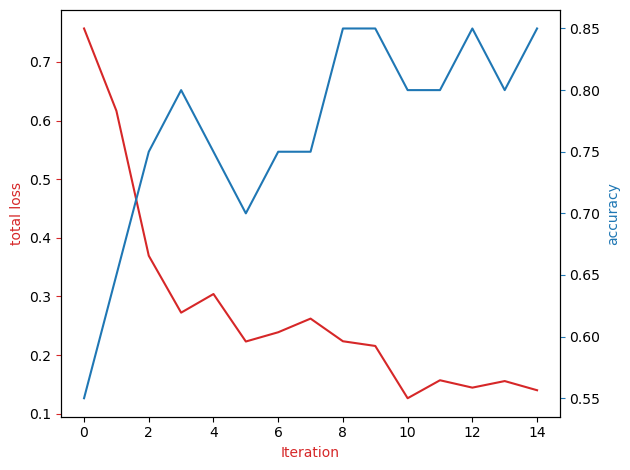

In [27]:
plot_stuff(loss_list,accuracy_list)

Load the model that performs best:


In [28]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.load_state_dict(torch.load( "model.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
def make_single_prediction(model, image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image.convert("RGB")
    transform = transforms.Compose(
                        [
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std),
                        ]
                    )
    tensor = transform(image)
    # Add a batch dimension of size 1 to the tensor
    tensor = tensor.unsqueeze(0)

    # Make the prediction
    output = model(tensor)
    prediction = output.argmax(dim=1, keepdim=True)

    labels_types = annotations["labels"]
    print("The prediction is: " + labels_types[prediction.item()])

    # Plot the input image
    imshow_(tensor[0], labels_types[prediction.item()])

    # Return the prediction
    return prediction


In [30]:
def apply_function_to_images(folder):
    for file in os.listdir(folder):
        # Check if file is an image
        if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
            file_path = os.path.join(folder, file)
            # Apply function to image
            image = Image.open(file_path)
            prediction = make_single_prediction(model, image)   

The prediction is: not_stop
(224, 224, 3)


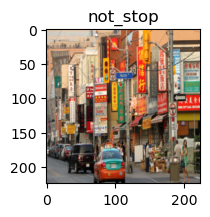

The prediction is: stop
(224, 224, 3)


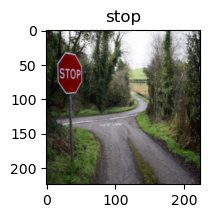

The prediction is: stop
(224, 224, 3)


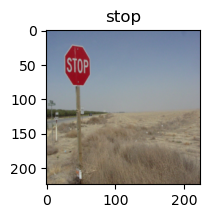

The prediction is: stop
(224, 224, 3)


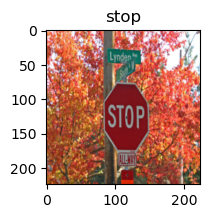

The prediction is: not_stop
(224, 224, 3)


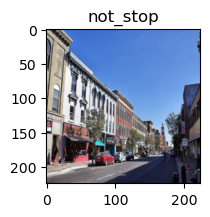

The prediction is: stop
(224, 224, 3)


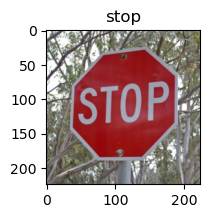

The prediction is: not_stop
(224, 224, 3)


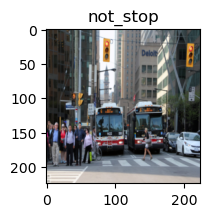

The prediction is: not_stop
(224, 224, 3)


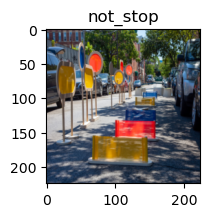

In [31]:
apply_function_to_images('test_set_stop_not_stop')

The prediction is: stop
(224, 224, 3)


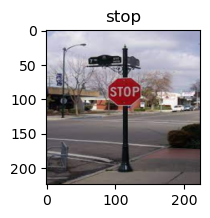

The prediction is: not_stop
(224, 224, 3)


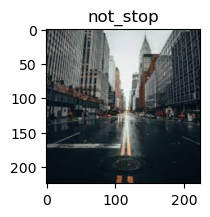

The prediction is: stop
(224, 224, 3)


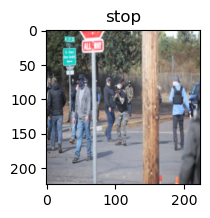

The prediction is: stop
(224, 224, 3)


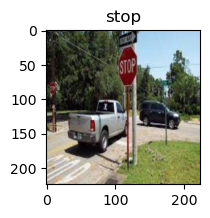

The prediction is: stop
(224, 224, 3)


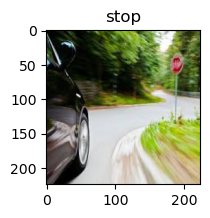

The prediction is: stop
(224, 224, 3)


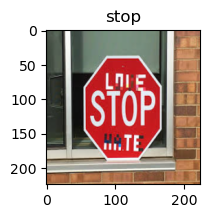

The prediction is: stop
(224, 224, 3)


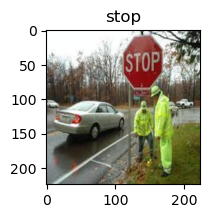

The prediction is: stop
(224, 224, 3)


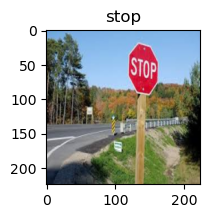

The prediction is: not_stop
(224, 224, 3)


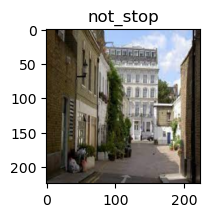

The prediction is: not_stop
(224, 224, 3)


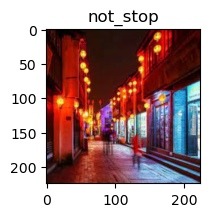

The prediction is: not_stop
(224, 224, 3)


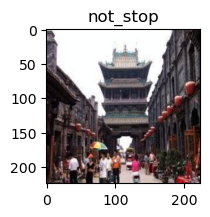

The prediction is: stop
(224, 224, 3)


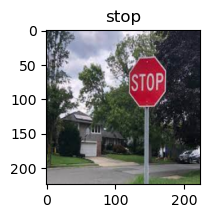

The prediction is: not_stop
(224, 224, 3)


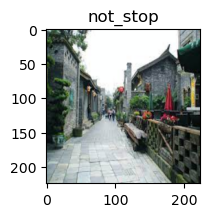

The prediction is: not_stop
(224, 224, 3)


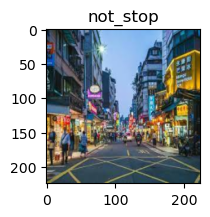

The prediction is: not_stop
(224, 224, 3)


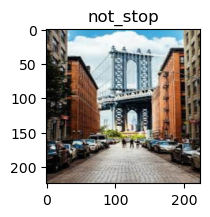

The prediction is: not_stop
(224, 224, 3)


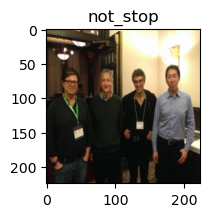

In [32]:
apply_function_to_images("test_images")